In [1]:
import pystencils as ps
from pystencils import plot as plt

import numpy as np
import sympy as sp

# Tutorial 01: Getting Started


## Overview

*pystencils* is a package that can speed up computations on *numpy* arrays. All computations are carried out fully parallel on CPUs (single node with OpenMP, multiple nodes with MPI) or on GPUs.
It is suited for applications that run the same operation on *numpy* arrays multiple times. It can be used to accelerate computations on images or voxel fields. Its main application, however, are numerical simulations using finite differences, finite volumes, or lattice Boltzmann methods. 
There already exist a variety of packages to speed up numeric Python code. One could use pure numpy or solutions that compile your code, like *Cython* and *numba*. See [this page](demo_benchmark.ipynb) for a comparison of these tools.

![Stencil](../img/pystencils_stencil_four_points_with_arrows.svg)

As the name suggests, *pystencils* was developed for **stencil codes**, i.e. operations that update array elements using only a local neighborhood. 
It generates C code, compiles it behind the scenes, and lets you call the compiled C function as if it was a native Python function. 
But lets not dive too deep into the concepts of *pystencils* here, they are covered in detail in the following tutorials. Let's instead look at a simple example, that computes the average neighbor values of a *numpy* array. Therefor we first create two rather large arrays for input and output:

In [2]:
input_arr = np.random.rand(1024, 1024)
output_arr = np.zeros_like(input_arr)

We first implement a version of this algorithm using pure numpy and benchmark it.

In [3]:
def numpy_kernel():
    output_arr[1:-1, 1:-1] = input_arr[2:, 1:-1] + input_arr[:-2, 1:-1] + \
                             input_arr[1:-1, 2:] + input_arr[1:-1, :-2]

In [4]:
%%timeit 
numpy_kernel()

4.65 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now lets see how to run the same algorithm with *pystencils*.

In [5]:
src, dst = ps.fields(src=input_arr, dst=output_arr)

symbolic_description = ps.Assignment(dst[0,0], 
                                     (src[1, 0] + src[-1, 0] + src[0, 1] + src[0, -1]) / 4)
symbolic_description

Assignment(dst_C, src_E/4 + src_N/4 + src_S/4 + src_W/4)

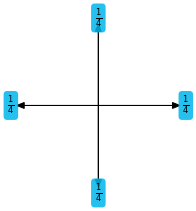

In [6]:
plt.figure(figsize=(3,3))
ps.stencil.plot_expression(symbolic_description.rhs)

Here we first have created a symbolic notation of the stencil itself. This representation is built on top of *sympy* and is explained in detail in the next section. 
This description is then compiled and loaded as a Python function.

In [7]:
kernel = ps.create_kernel(symbolic_description).compile()

This whole process might seem overly complicated. We have already spent more lines of code than we needed for the *numpy* implementation and don't have anything running yet! However, this multi-stage process of formulating the algorithm symbolically, and just in the end actually running it, is what makes *pystencils* faster and more flexible than other approaches.

Now finally lets benchmark the *pystencils* kernel.

In [8]:
def pystencils_kernel():
    kernel(src=input_arr, dst=output_arr)

In [9]:
%%timeit
pystencils_kernel()

951 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This benchmark shows that *pystencils* is a lot faster than pure *numpy*, especially for large arrays. 
If you are interested in performance details and comparison to other packages like Cython, have a look at [this page](demo_benchmark.ipynb).



## Short *sympy* introduction

In this tutorial we continue with a short *sympy* introduction, since the symbolic kernel definition is built on top of this package. If you already know *sympy* you can skip this section. 
You can also read the full [sympy documentation here](http://docs.sympy.org/latest/index.html).

In [10]:
import sympy as sp
sp.init_printing()  # enable nice LaTeX output

*sympy* is a package for symbolic calculation. So first we need some symbols:

In [11]:
x = sp.Symbol("x")
y = sp.Symbol("y")
type(x)

sympy.core.symbol.Symbol

The usual mathematical operations are defined for symbols:

In [12]:
expr = x**2 * ( y + x + 5) + x**2
expr

Now we can do all sorts of operations on these expressions: expand them, factor them, substitute variables:

In [13]:
expr.expand()

In [14]:
expr.factor()

In [15]:
expr.subs(y, sp.cos(x))

We can also built equations and solve them

In [16]:
eq = sp.Eq(expr, 1)
eq

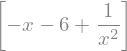

In [17]:
sp.solve(sp.Eq(expr, 1), y)

A *sympy* expression is represented by an abstract syntax tree (AST), which can be inspected and modified.

In [18]:
expr

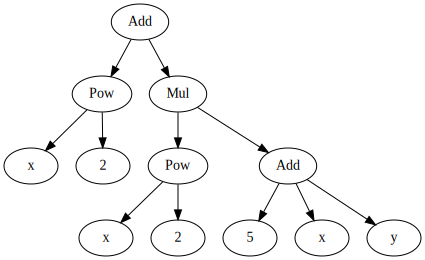

In [19]:
ps.to_dot(expr, graph_style={'size': "9.5,12.5"} )

Programatically the children node type is acessible as ``expr.func`` and its children as ``expr.args``.
With these members a tree can be traversed and modified.

In [20]:
expr.func

sympy.core.add.Add

In [21]:
expr.args

## Using *pystencils* 


### Fields

*pystencils* is a module to generate code for stencil operations. 
One has to specify an update rule for each element of an array, with optional dependencies to neighbors.
This is done use pure *sympy* with one addition: **Fields**.

Fields represent a multidimensional array, where some dimensions are considered *spatial*, and some as *index* dimensions. Spatial coordinates are given relative (i.e. one can specify "the current cell" and "the left neighbor") whereas index dimensions are used to index multiple values per cell.

In [22]:
my_field = ps.fields("f(3) : double[2D]")

Neighbors are labeled according to points on a compass where the first coordinate is west/east, second coordinate north/south and third coordinate top/bottom. 

In [23]:
field_access = my_field[1, 0](1)
field_access

The result of indexing a field is an instance of ``Field.Access``. This class is a subclass of a *sympy* Symbol and thus can be used whereever normal symbols can be used. It is just like a normal symbol with some additional information attached to it.

In [24]:
isinstance(field_access, sp.Symbol)

True

### Building our first stencil kernel

Lets start by building a simple filter kernel. We create a field representing an image, then define a edge detection filter on the third pixel component which is blue for an RGB image.

In [25]:
img_field = ps.fields("img(4): [2D]")

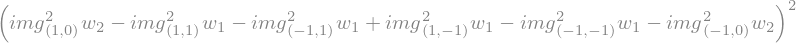

In [26]:
w1, w2 = sp.symbols("w_1 w_2")
color = 2
sobel_x = (-w2 * img_field[-1,0](color) - w1 * img_field[-1,-1](color) - w1 * img_field[-1, +1](color) \
           +w2 * img_field[+1,0](color) + w1 * img_field[+1,-1](color) - w1 * img_field[+1, +1](color))**2
sobel_x

We have mixed some standard *sympy* symbols into this expression to possibly give the different directions different weights. The complete expression is still a valid *sympy* expression, so all features of *sympy* work on it. Lets for example now fix one weight by substituting it with a constant.

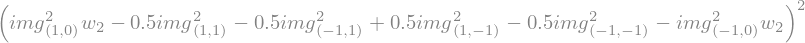

In [27]:
sobel_x = sobel_x.subs(w1, 0.5)
sobel_x

Now lets built an executable kernel out of it, which writes the result to a second field. Assignments are created using *pystencils* `Assignment` class, that gets the left- and right hand side of the assignment.

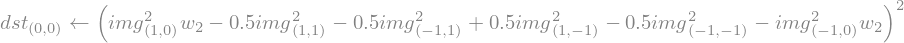

In [28]:
dst_field = ps.fields('dst: [2D]' )
update_rule = ps.Assignment(dst_field[0,0], sobel_x)
update_rule

Next we can see *pystencils* in action which creates a kernel for us.

In [29]:
from pystencils import create_kernel
ast = create_kernel(update_rule, cpu_openmp=False)
compiled_kernel = ast.compile()

This compiled kernel is now just an ordinary Python function. 
Now lets grab an image to apply this filter to:

In [30]:
try:
    import requests
    import imageio
    from io import BytesIO

    response = requests.get("https://www.python.org/static/community_logos/python-logo-master-v3-TM.png")
    img = imageio.imread(BytesIO(response.content)).astype(np.double)
    img /= img.max()
    plt.imshow(img);
except ImportError:
    print("No requests installed")
    img = np.random.random((82, 290, 4))

No requests installed


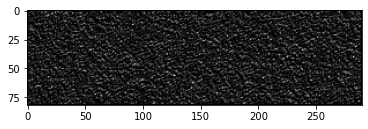

In [31]:
filtered_image = np.zeros_like(img[..., 0])
# here we call the compiled stencil function
compiled_kernel(img=img, dst=filtered_image, w_2=0.5)
plt.imshow(filtered_image, cmap='gray');

### Digging into *pystencils*

On our way we have created an ``ast``-object. We can inspect this, to see what *pystencils* actually does.

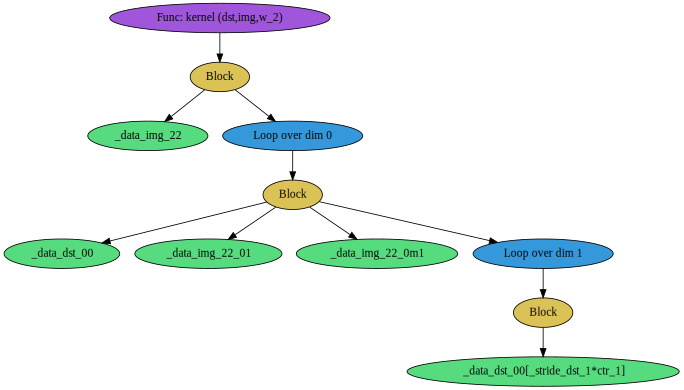

In [32]:
ps.to_dot(ast, graph_style={'size': "9.5,12.5"})

*pystencils* also builds a tree structure of the program, where each `Assignment` node internally again has a *sympy* AST which is not printed here. Out of this representation *C* code can be generated:

In [33]:
ps.show_code(ast)

FUNC_PREFIX void kernel(double * RESTRICT  _data_dst, double * RESTRICT const _data_img, int64_t const _size_dst_0, int64_t const _size_dst_1, int64_t const _stride_dst_0, int64_t const _stride_dst_1, int64_t const _stride_img_0, int64_t const _stride_img_1, int64_t const _stride_img_2, double w_2)
{
   double * RESTRICT _data_img_22 = _data_img + 2*_stride_img_2;
   for (int64_t ctr_0 = 1; ctr_0 < _size_dst_0 - 1; ctr_0 += 1)
   {
      double * RESTRICT  _data_dst_00 = _data_dst + _stride_dst_0*ctr_0;
      double * RESTRICT _data_img_22_01 = _stride_img_0*ctr_0 + _stride_img_0 + _data_img_22;
      double * RESTRICT _data_img_22_0m1 = _stride_img_0*ctr_0 - _stride_img_0 + _data_img_22;
      for (int64_t ctr_1 = 1; ctr_1 < _size_dst_1 - 1; ctr_1 += 1)
      {
         _data_dst_00[_stride_dst_1*ctr_1] = pow(w_2*-1.0*_data_img_22_0m1[_stride_img_1*ctr_1] + w_2*_data_img_22_01[_stride_img_1*ctr_1] - 0.5*_data_img_22_01[_stride_img_1*ctr_1 + _stride_img_1] - 0.5*_data_img_22_0m1[_stride_img_1*ctr_1 + _stride_img_1] - 0.5*_data_img_22_0m1[_stride_img_1*ctr_1 - _stride_img_1] + 0.5*_data_img_22_01[_stride_img_1*ctr_1 - _stride_img_1], 2);
      }
   }
}

Behind the scenes this code is compiled into a shared library and made available as a Python function. Before compiling this function we can modify the AST object, for example to parallelize it with OpenMP.

In [34]:
ast = ps.create_kernel(update_rule)
ps.cpu.add_openmp(ast, num_threads=2)
ps.show_code(ast)

FUNC_PREFIX void kernel(double * RESTRICT  _data_dst, double * RESTRICT const _data_img, int64_t const _size_dst_0, int64_t const _size_dst_1, int64_t const _stride_dst_0, int64_t const _stride_dst_1, int64_t const _stride_img_0, int64_t const _stride_img_1, int64_t const _stride_img_2, double w_2)
{
   #pragma omp parallel num_threads(2)
   {
      double * RESTRICT _data_img_22 = _data_img + 2*_stride_img_2;
      #pragma omp for schedule(static)
      for (int64_t ctr_0 = 1; ctr_0 < _size_dst_0 - 1; ctr_0 += 1)
      {
         double * RESTRICT  _data_dst_00 = _data_dst + _stride_dst_0*ctr_0;
         double * RESTRICT _data_img_22_01 = _stride_img_0*ctr_0 + _stride_img_0 + _data_img_22;
         double * RESTRICT _data_img_22_0m1 = _stride_img_0*ctr_0 - _stride_img_0 + _data_img_22;
         for (int64_t ctr_1 = 1; ctr_1 < _size_dst_1 - 1; ctr_1 += 1)
         {
            _data_dst_00[_stride_dst_1*ctr_1] = pow(w_2*-1.0*_data_img_22_0m1[_stride_img_1*ctr_1] + w_2*_data_img_22_01[_stride_img_1*ctr_1] - 0.5*_data_img_22_01[_stride_img_1*ctr_1 + _stride_img_1] - 0.5*_data_img_22_0m1[_stride_img_1*ctr_1 + _stride_img_1] - 0.5*_data_img_22_0m1[_stride_img_1*ctr_1 - _stride_img_1] + 0.5*_data_img_22_01[_stride_img_1*ctr_1 - _stride_img_1], 2);
         }
      }
   }
}

In [35]:
loops = list(ast.atoms(ps.astnodes.LoopOverCoordinate))
l1 = loops[0]
l1.prefix_lines.append("#pragma something")
l1.is_outermost_loop

False

### Fixed array sizes

Since we already know the arrays to which the kernel should be applied, we can 
create *Field* objects with fixed size, based on a numpy array:

In [36]:
img_field, dst_field = ps.fields("I(4), dst : [2D]", I=img.astype(np.double), dst=filtered_image)

sobel_x = -2 * img_field[-1,0](1) - img_field[-1,-1](1) - img_field[-1, +1](1) \
         +2 * img_field[+1,0](1) + img_field[+1,-1](1) - img_field[+1, +1](1)
update_rule = ps.Assignment(dst_field[0,0], sobel_x)

ast = create_kernel(update_rule)
ps.show_code(ast)

FUNC_PREFIX void kernel(double * RESTRICT const _data_I, double * RESTRICT  _data_dst)
{
   double * RESTRICT _data_I_21 = _data_I + 1;
   for (int64_t ctr_0 = 1; ctr_0 < 81; ctr_0 += 1)
   {
      double * RESTRICT  _data_dst_00 = _data_dst + 290*ctr_0;
      double * RESTRICT _data_I_21_01 = _data_I_21 + 1160*ctr_0 + 1160;
      double * RESTRICT _data_I_21_0m1 = _data_I_21 + 1160*ctr_0 - 1160;
      for (int64_t ctr_1 = 1; ctr_1 < 289; ctr_1 += 1)
      {
         _data_dst_00[ctr_1] = -1.0*_data_I_21_01[4*ctr_1 + 4] - 1.0*_data_I_21_0m1[4*ctr_1 + 4] - 1.0*_data_I_21_0m1[4*ctr_1 - 4] - 2.0*_data_I_21_0m1[4*ctr_1] + 2.0*_data_I_21_01[4*ctr_1] + _data_I_21_01[4*ctr_1 - 4];
      }
   }
}

Compare this code to the version above. In this code the loop bounds and array offsets are constants, which usually leads to faster kernels.

### Running on GPU

If you have a CUDA enabled graphics card and [pycuda](https://mathema.tician.de/software/pycuda/) installed, *pystencils* can run your kernel on the GPU as well. You can find more details about this in the GPU tutorial.

In [37]:
try:
    import pycuda
    from pystencils.gpucuda import BlockIndexing

    gpu_ast = create_kernel(update_rule, target=ps.Target.GPU,
                            gpu_indexing=BlockIndexing,
                            gpu_indexing_params={'blockSize': (64, 1, 1)})

    ps.show_code(ast)
except ImportError:
    print("Please install pycuda for GPU support")

FUNC_PREFIX void kernel(double * RESTRICT const _data_I, double * RESTRICT  _data_dst)
{
   double * RESTRICT _data_I_21 = _data_I + 1;
   for (int64_t ctr_0 = 1; ctr_0 < 81; ctr_0 += 1)
   {
      double * RESTRICT  _data_dst_00 = _data_dst + 290*ctr_0;
      double * RESTRICT _data_I_21_01 = _data_I_21 + 1160*ctr_0 + 1160;
      double * RESTRICT _data_I_21_0m1 = _data_I_21 + 1160*ctr_0 - 1160;
      for (int64_t ctr_1 = 1; ctr_1 < 289; ctr_1 += 1)
      {
         _data_dst_00[ctr_1] = -1.0*_data_I_21_01[4*ctr_1 + 4] - 1.0*_data_I_21_0m1[4*ctr_1 + 4] - 1.0*_data_I_21_0m1[4*ctr_1 - 4] - 2.0*_data_I_21_0m1[4*ctr_1] + 2.0*_data_I_21_01[4*ctr_1] + _data_I_21_01[4*ctr_1 - 4];
      }
   }
}